In [1]:
import pandas as pd
import geopandas as gpd
from h3 import h3
from shapely.geometry import Polygon, LineString


In [2]:
def h3_from_row(row,res,x,y):
    '''
    Esta funcion toma una fila, un nivel de resolucion de h3
    y los nombres que contienen las coordenadas xy
    y devuelve un id de indice h3
    '''
    return h3.geo_to_h3(row[y],row[x],res = res)

def h3_indexing(df,res_list,lat_d='lat_d',lon_d='lon_d',lat_o='lat_o',lon_o='lon_o'):
    """
    Esta funcion toma una tabla con dos pares de coordenadas para origen y destino
    Un nivel de resolucion h3
    y devuelve la tabla con los ids de h3
    """
    
    if len(res_list) == 1:
        res_list.append(res_list[0])
        
    for res in range(res_list[0],res_list[1] + 1):
        df['h3_o_res_' + str(res)] = df.apply(h3_from_row, axis=1, args=[res,lon_o,lat_o])
        df['h3_d_res_' + str(res)] = df.apply(h3_from_row, axis=1, args=[res,lon_d,lat_d])

    return df



In [3]:
ruta_tramos = '../data/tabla_tramos_completos_epsg4326.csv'
ruta_viajes = '../data/tabla_viajes_completos_epsg4326.csv'

In [4]:
tramos = pd.read_csv(ruta_tramos)
tramos.head()

,tarjeta,linea,fecha,delta,tramo_id,dia,lat_d,lon_d,lat_o,lon_o
0,30,LINEA_C_SFE,2019-05-06T08:25:57,0 days 00:44:39,0,6,-31.645405,-60.707708,-31.65905,-60.77800
1,30,LINEA_002_SFE,2019-05-06T09:10:36,0 days 03:23:40,1,6,-31.640794,-60.670139,-31.64518,-60.70880
2,30,LINEA_002_SFE,2019-05-06T12:34:16,0 days 00:19:34,2,6,-31.639712,-60.707264,-31.64079,-60.67014
3,30,LINEA_C_SFE,2019-05-06T12:53:50,0 days 17:01:15,3,6,-31.659049,-60.778000,-31.63915,-60.70984
4,30,LINEA_C_SFE,2019-05-07T05:55:05,0 days 00:35:31,4,7,-31.647706,-60.708363,-31.65936,-60.77595


In [5]:
viajes = pd.read_csv(ruta_viajes)
viajes.head()

,tarjeta,dia,viaje_id,linea,fecha,tramos,lat_o,lon_o,lat_d,lon_d
0,30,6,0,LINEA_C_SFE - LINEA_002_SFE,2019-05-06T08:25:57,2,-31.65905,-60.77800,-31.640794,-60.670139
1,30,6,1,LINEA_002_SFE - LINEA_C_SFE,2019-05-06T12:34:16,2,-31.64079,-60.67014,-31.659049,-60.778000
2,30,7,0,LINEA_C_SFE - LINEA_002_SFE,2019-05-07T05:55:05,2,-31.65936,-60.77595,-31.640219,-60.666560
3,30,7,1,LINEA_002_SFE - LINEA_C_SFE,2019-05-07T10:49:15,2,-31.64022,-60.66656,-31.659390,-60.775957
4,63,6,0,LINEA_008_SFE,2019-05-06T08:53:03,1,-31.62568,-60.68977,-31.648135,-60.711276


In [6]:
resolucion_grande = 6
resolucion_chica = 10

In [7]:
%time h3_tramos = h3_indexing(tramos.copy(),res_list = [resolucion_grande,resolucion_chica])

CPU times: user 17.2 s, sys: 130 ms, total: 17.4 s
Wall time: 17.4 s


In [8]:
%time h3_viajes = h3_indexing(viajes.copy(),res_list = [resolucion_grande,resolucion_chica])

CPU times: user 12.7 s, sys: 27.7 ms, total: 12.8 s
Wall time: 12.7 s


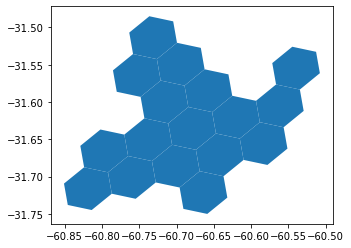

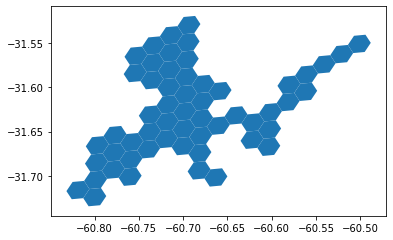

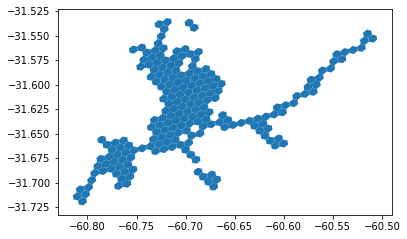

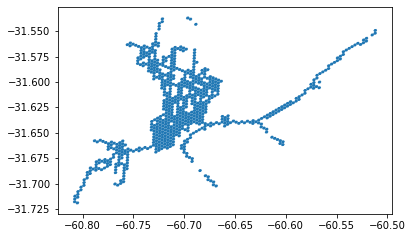

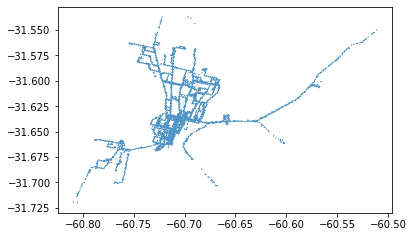

In [11]:
#crear cartografias para tramos
for resolucion in range(resolucion_grande,resolucion_chica+1):
#for resolucion in range(8,9):
    #crear tabla con OD por hexagrilla
    par_OD_resolucion = ['h3_o_res_%s'%(resolucion),'h3_d_res_%s'%(resolucion)]
    tabla_OD = h3_tramos.reindex(columns = par_OD_resolucion).groupby(par_OD_resolucion).size().reset_index()
    tabla_OD.columns = par_OD_resolucion +['n']
    tabla_OD[par_OD_resolucion[1]].replace({'0':'Desconocido'},inplace=True) 
    tabla_OD.to_csv('../data/tabla_tramos_OD_res_%s.csv'%(resolucion),index=False)


    # cartografia de todas las hexagrillas de una resolucion dada
    lista_indices_global = pd.concat([pd.Series(h3_tramos['h3_o_res_%s'%(resolucion)].unique()),
                                      pd.Series(h3_tramos['h3_d_res_%s'%(resolucion)].unique())]).unique()
    
    # indice para los None
    lista_indices_global = lista_indices_global[lista_indices_global!='0']
    geo_df = gpd.GeoDataFrame(lista_indices_global, geometry = [Polygon(h3.h3_to_geo_boundary(h3_address=h,geo_json=True)) \
                                          for h in lista_indices_global],\
                              crs = 'EPSG:4326')
    geo_df.columns=['h3_index','geometry']
    geo_df.plot()
    geo_df.to_file('../carto/carto_tramos_hex_res_%s.geojson'%(resolucion),driver='GeoJSON')
    
    #crear cartografia de recorridos para una resolucion dada
    
    tabla_OD = tabla_OD.loc[tabla_OD[par_OD_resolucion[1]]!='Desconocido']
    geometria = [LineString([h3.h3_to_geo(tabla_OD.loc[i][par_OD_resolucion[0]])[::-1],
            h3.h3_to_geo(tabla_OD.loc[i][par_OD_resolucion[1]])[::-1]
                            ]
                           ) for i in tabla_OD.index]    
    geo_df = gpd.GeoDataFrame(tabla_OD, geometry = geometria,crs = 'EPSG:4326')
    geo_df.to_file('../carto/recorridos_tramos_res_%s.geojson'%(resolucion),driver='GeoJSON')


In [12]:
geo_df.head()

,h3_o_res_10,h3_d_res_10,n,geometry
0,8ab24d229c1ffff,8ab24d341477fff,1,"LINESTRING (-60.80550 -31.72006, -60.72543 -31..."
1,8ab24d22d097fff,8ab24d342717fff,1,"LINESTRING (-60.80286 -31.70654, -60.76211 -31..."
2,8ab24d22d187fff,8ab24d342747fff,1,"LINESTRING (-60.80152 -31.70345, -60.75820 -31..."
3,8ab24d22d19ffff,8ab24d34245ffff,1,"LINESTRING (-60.80196 -31.70448, -60.76407 -31..."
4,8ab24d22d19ffff,8ab24d36ada7fff,1,"LINESTRING (-60.80196 -31.70448, -60.70660 -31..."


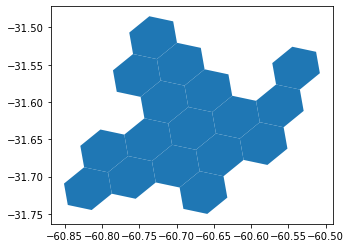

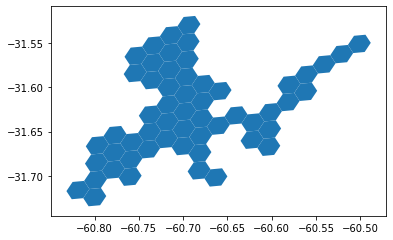

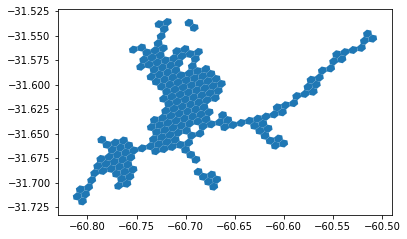

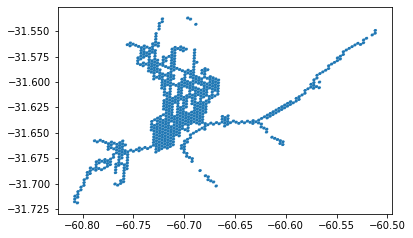

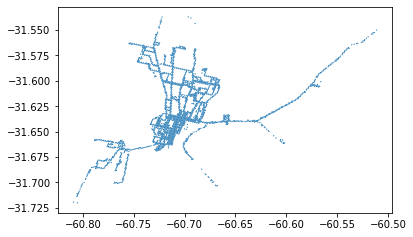

In [13]:
#crear cartografias para viajes
for resolucion in range(resolucion_grande,resolucion_chica+1):
#for resolucion in range(8,9):
    #crear tabla con OD por hexagrilla
    par_OD_resolucion = ['h3_o_res_%s'%(resolucion),'h3_d_res_%s'%(resolucion)]
    tabla_OD = h3_viajes.reindex(columns = par_OD_resolucion).groupby(par_OD_resolucion).size().reset_index()
    tabla_OD.columns = par_OD_resolucion +['n']
    tabla_OD[par_OD_resolucion[1]].replace({'0':'Desconocido'},inplace=True) 
    tabla_OD.to_csv('../data/tabla_viajes_OD_res_%s.csv'%(resolucion),index=False)


    # cartografia de todas las hexagrillas de una resolucion dada
    lista_indices_global = pd.concat([pd.Series(h3_viajes['h3_o_res_%s'%(resolucion)].unique()),
                                      pd.Series(h3_viajes['h3_d_res_%s'%(resolucion)].unique())]).unique()
    
    # indice para los None
    lista_indices_global = lista_indices_global[lista_indices_global!='0']
    geo_df = gpd.GeoDataFrame(lista_indices_global, geometry = [Polygon(h3.h3_to_geo_boundary(h3_address=h,geo_json=True)) \
                                          for h in lista_indices_global],\
                              crs = 'EPSG:4326')
    geo_df.columns=['h3_index','geometry']
    geo_df.plot()
    geo_df.to_file('../carto/carto_viajes_hex_res_%s.geojson'%(resolucion),driver='GeoJSON')
    
    #crear cartografia de recorridos para una resolucion dada
    
    tabla_OD = tabla_OD.loc[tabla_OD[par_OD_resolucion[1]]!='Desconocido']
    geometria = [LineString([h3.h3_to_geo(tabla_OD.loc[i][par_OD_resolucion[0]])[::-1],
            h3.h3_to_geo(tabla_OD.loc[i][par_OD_resolucion[1]])[::-1]
                            ]
                           ) for i in tabla_OD.index]    
    geo_df = gpd.GeoDataFrame(tabla_OD, geometry = geometria,crs = 'EPSG:4326')
    geo_df.to_file('../carto/recorridos_viajes_res_%s.geojson'%(resolucion),driver='GeoJSON')


In [ ]:
#crear cartografias
tipo = 'destinos' #'origenes' 
resolucion = 9
columna = 'h3_%s_res_%s'%(tipo[0],resolucion)
columna

In [ ]:
#cartografia por tipo
agg_table = h3_dt.reindex(columns = [columna])\
    .groupby(columna)\
    .size().reset_index()
agg_table.columns = [columna,tipo]
agg_table = agg_table.loc[agg_table[columna]!='0',:]
agg_table.head()

In [ ]:
geo_df = gpd.GeoDataFrame(agg_table, geometry = [Polygon(h3.h3_to_geo_boundary(h3_address=h,geo_json=True)) \
                                      for h in agg_table[columna]],\
                          crs = 'EPSG:4326'
)
geo_df.plot(column = tipo,scheme='Quantiles',k=5)